In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
import re
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Set Parameters
DATA_ROOT = '/home/shawn103/brain_MRI_segmenation_tutorial/kaggle_3m'

In [3]:
train_files = []
mask_files = []

pattern = os.path.join(DATA_ROOT,'T*')
folders = sorted(glob(pattern))
for curr_folder in folders:
    curr_pattern = os.path.join(curr_folder,'*_mask*')
    curr_files = glob(curr_pattern)
    curr_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    mask_files.extend(curr_files)

for i in mask_files:
    train_files.append(i.replace('_mask',''))

from pathlib import Path

def positive_negative_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return 1 if value > 0 else 0
    
positives = []
IDs = []

for curr_mask_path in mask_files:
    positives.append(positive_negative_diagnosis(curr_mask_path))
    IDs.append(Path(curr_mask_path).parent.name)
    
df = pd.DataFrame(data={"ID": IDs, "filename": train_files, 'mask_path' : mask_files,'diagnosis': positives})
df

,ID,filename,mask_path,diagnosis
0,TCGA_CS_4941_19960909,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
1,TCGA_CS_4941_19960909,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
2,TCGA_CS_4941_19960909,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
3,TCGA_CS_4941_19960909,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
4,TCGA_CS_4941_19960909,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
3925,TCGA_HT_A61B_19991127,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
3926,TCGA_HT_A61B_19991127,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0
3927,TCGA_HT_A61B_19991127,/home/shawn103/brain_MRI_segmenation_tutorial/...,/home/shawn103/brain_MRI_segmenation_tutorial/...,0


# Generator

In [4]:
img_list=list(range(5))
for i in img_list:
    print('%d.jpg '%i, end='')

0.jpg 1.jpg 2.jpg 3.jpg 4.jpg 

In [5]:
def get_data(data):
    for i in data:
        yield "read %d.jpg and return img"%i
    
my_generator = get_data(img_list)   

In [6]:
print(next(iter(my_generator)))

read 0.jpg and return img


## ImageDataGenerator

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator()

image_generator = image_datagen.flow_from_dataframe(
    df,
    x_col = "filename",
    class_mode = None,
    color_mode = 'rgb',
    target_size = (256,256),
    batch_size = 1,
    save_to_dir = None,
    save_prefix  = None,
    seed = 1,
    shuffle = False)

Found 3929 validated image filenames.


images.shape:  (1, 256, 256, 3)


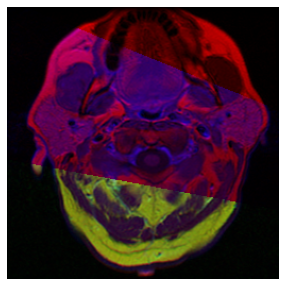

In [8]:
def show_aug1(inputs, nrows=5, ncols=5):
    plt.figure(figsize=(5*ncols, 5*nrows))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
            
    for idx in range(len(inputs)):
        img = np.asarray(inputs[idx]).astype(np.uint8)
        plt.subplot(nrows, ncols, i_+1)        
        plt.imshow(img); 
        plt.axis('off')
        i_ += 1
        
    return plt.show()

images = next(iter(image_generator))
print('images.shape: ',images.shape)
show_aug1(images)

# 牛刀小試5
## 同時顯示Augmentation圖與原始圖
# 牛刀小試6
## 嘗試不同參數

In [130]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

aug_image_datagen = ImageDataGenerator(**train_generator_args)
???

aug_image_generator = aug_image_datagen.flow_from_dataframe(
    df,
    x_col = "filename",
    class_mode = None,
    color_mode = 'rgb',
    target_size = (256,256),
    batch_size = 1,
    save_to_dir = None,
    save_prefix  = None,
    seed = 1,
    shuffle = False)

no_aug_image_generator = ???
???
...
???

SyntaxError: invalid syntax (769885074.py, line 26)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

aug_image_datagen = ImageDataGenerator(**train_generator_args)
no_aug_image_datagen = ImageDataGenerator()

aug_image_generator = aug_image_datagen.flow_from_dataframe(
    df,
    x_col = "filename",
    class_mode = None,
    color_mode = 'rgb',
    target_size = (256,256),
    batch_size = 1,
    save_to_dir = None,
    save_prefix  = None,
    seed = 1,
    shuffle = False)
no_aug_image_generator = no_aug_image_datagen.flow_from_dataframe(
    df,
    x_col = "filename",
    class_mode = None,
    color_mode = 'rgb',
    target_size = (256,256),
    batch_size = 1,
    save_to_dir = None,
    save_prefix  = None,
    seed = 1,
    shuffle = False)

Found 3929 validated image filenames.
Found 3929 validated image filenames.


Aug:


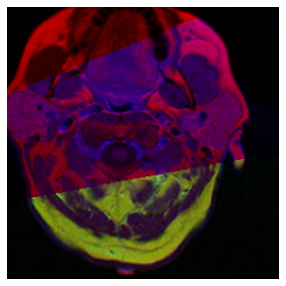

Original:


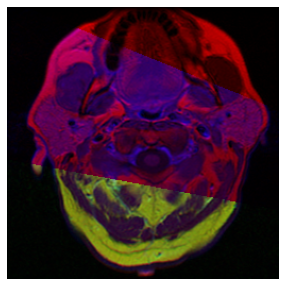

In [12]:
images = next(iter(aug_image_generator))
print('Aug:')
show_aug1(images)

images = next(iter(no_aug_image_generator))
print('Original:')
show_aug1(images)

## Data & Mask Generator

In [13]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1,
        shuffle=True):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        shuffle = shuffle)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,    ##  grayscale
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        shuffle = shuffle)

    train_gen = zip(image_generator, mask_generator)  ##
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [14]:
train_generator_args1 = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

train_generator_args2 = dict(rotation_range=0,
                        width_shift_range=0,
                        height_shift_range=0,
                        shear_range=0,
                        zoom_range=0,
                        horizontal_flip=False,
                        fill_mode='nearest')

im_width = 256
im_height = 256

train_gen = train_generator(df, 5,
                train_generator_args1,
                target_size=(im_height, im_width),
                shuffle = True)

train_gen_no_aug = train_generator(df, 5,
                train_generator_args2,
                target_size=(im_height, im_width),
                shuffle = True)

Found 3929 validated image filenames.
Found 3929 validated image filenames.
(5, 256, 256, 3) (5, 256, 256, 1)
Augmentation:


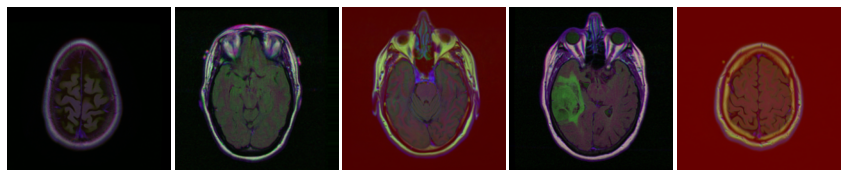

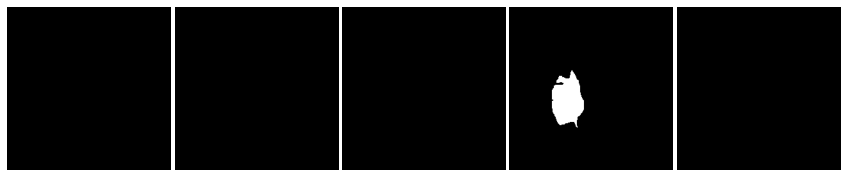

Found 3929 validated image filenames.
Found 3929 validated image filenames.
(5, 256, 256, 3) (5, 256, 256, 1)
Original:


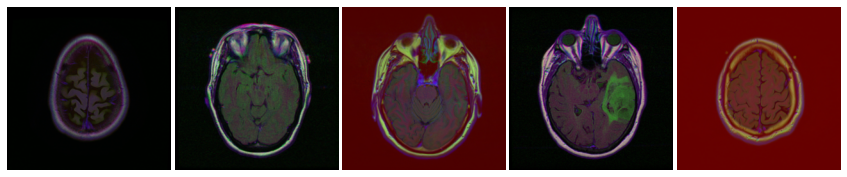

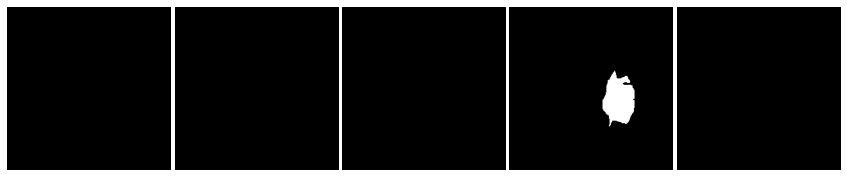

In [15]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:
            img = np.asarray(inputs[idx])
        else:
            img = np.asarray(inputs[idx])
            img = np.concatenate([img]*3,axis=2)
            
        plt.subplot(nrows, ncols, i_+1)        
        plt.imshow(img); 
        plt.axis('off')
        i_ += 1
        
    return plt.show()

images, masks = next(iter(train_gen))
print(images.shape, masks.shape)
print('Augmentation:')
show_aug(images)
show_aug(masks, image=False)

images, masks = next(iter(train_gen_no_aug))
print(images.shape, masks.shape)
print('Original:')
show_aug(images)
show_aug(masks, image=False)
